In [1]:
# テスト用のデータの作成
# 自分で用意したデータを利用するときには不要．
import autograd
import autograd.numpy as np
import scipy.integrate
solver = scipy.integrate.solve_ivp

N = 1
# 行列 S に摩擦などに関する項を追加する．
O = np.zeros((N,N))
Id = np.eye(N)
dId = -0.1*Id
S = np.vstack([np.hstack([O, Id]), np.hstack([-Id, dId])])

# 調和振動子のエネルギー
def energy(u):
  return np.dot(u,u)

# 実験用データ作成のための右辺項
def odefunc(t,u):
  dhdu = autograd.grad(energy)(u)
  return np.matmul(S, dhdu)

# 初期条件．時刻 0 での値を適当に決めます．
u = np.zeros(2)
u[0] = 1
u[1] = 0

# シミュレーションを行う時間区間を設定し，それを細かく分割．
M = 100
tend = 10.0
t_eval = np.linspace(0, tend, M)
# データの時間間隔を計算し，dt という名前で保存．
dt = t_eval[1]-t_eval[0]

# 実際に微分方程式の解を計算．
# 解は solver の返り値の sol の中の 'y' という部分に保存される．
sol = solver(odefunc,[0, tend], u,t_eval=t_eval)
tval = sol['t']
q, p = sol['y'][0], sol['y'][1]

# Input: 対応する状態変数データの作成
#u_ave = (sol['y'][:,:-1]+sol['y'][:,1:])/2.0
xtmp = np.stack([q, p]).T
#x1 = xtmp[:,:-1].contiguous().view(-1, N)
#x2 = xtmp[:,1:].contiguous().view(-1, N)
x1 = xtmp[:-1,:]
x2 = xtmp[1:,:]
input_data = np.concatenate([x1, x2],axis=1)

# Target: 勾配データの作成（観測データから微分を推定するイメージで有限差分で作る）
dudt = (sol['y'][:,1:]-sol['y'][:,:-1])/dt

np.savetxt("target.csv",dudt.T,delimiter=',')
np.savetxt("input.csv",input_data,delimiter=',')

In [2]:
import torch
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd


MY_BATCH_SIZE = 100

# csv ファイルに保存したデータを読み込む
# 自分で用意したデータを読み込むためには，
#   Google ドライブにデータを保存しておき，
#   以下の命令でマウントし，読み込む．
#   drive/MyDrive が Google ドライブと同じ内容になる．

#from google.colab import drive
#drive.mount('/content/drive')

dftarget = pd.read_csv("target.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("input.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values,test_size=0.8)

# 学習用データ
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train,batch_size=MY_BATCH_SIZE,shuffle=True)

# テスト用データ
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test,batch_size=MY_BATCH_SIZE,shuffle=True)

In [3]:
# pytorch 関係のライブラリの読み込み
import torch
import torch.nn as nn
import torch.optim as optim
# 利用可能であれば GPU を使って計算．何か不具合が生じた場合は device = 'cpu' としましょう．
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [4]:
# dgnet および hnn から必要なファイルをダウンロード
!wget https://github.com/tksmatsubara/discrete-autograd/archive/master.zip
!unzip master.zip
!mv discrete-autograd-master/dgnet ./
!wget https://github.com/greydanus/hamiltonian-nn/blob/master/hnn.py
!wget https://github.com/greydanus/hamiltonian-nn/blob/master/nn_models.py
!wget https://github.com/greydanus/hamiltonian-nn/blob/master/utils.py

--2022-12-14 15:49:48--  https://github.com/tksmatsubara/discrete-autograd/archive/master.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tksmatsubara/discrete-autograd/zip/refs/heads/master [following]
--2022-12-14 15:49:48--  https://codeload.github.com/tksmatsubara/discrete-autograd/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ] 301.96K  --.-KB/s    in 0.08s   

2022-12-14 15:49:49 (3.59 MB/s) - ‘master.zip’ saved [309208]

Archive:  master.zip
e101a090510be1bed6926a2efa5bea5fb9a07e7c
   creating: discrete-autograd-master/
  inflating:

In [5]:
import dgnet
from dgnet.ode import DGNet
#from dgnet import Sequential
#from dgnet import get_decorated_module_by_name
from dgnet import *

# 多層パーセプトロンによる常微分方程式モデル．
# input_dim は状態変数の数．hidden_dim は隠れ層の大きさ．
# output_dim はエネルギーの値のみを出力するので 1 
input_dim = N*2
hidden_dim = 30
output_dim = 1

nonlinearity='tanh'
mynet = DGNet(input_dim, hidden_dim, nonlinearity=nonlinearity, friction=False, model='hnn', solver='dg')

# DGNet 用の tanh を用意
Act = get_decorated_module_by_name(nonlinearity)

# デフォルトモデルを利用しない場合には以下で設計する．
mynet.net = Sequential(
        Linear(input_dim, hidden_dim),
        Act(),
        Linear(hidden_dim, hidden_dim),
        Act(),
        Linear(hidden_dim, output_dim, bias=None),
    )

# モデルを計算用のデバイスに転送
mynet = mynet.to(device)

In [6]:
dtype = torch.get_default_dtype()
torch.set_grad_enabled(False)

# 学習回数を設定
num_epochs = 10000

# 誤差の計算方法を指定
criterion = nn.MSELoss()

# 学習アルゴリズムとパラメータを指定
optimizer = optim.Adam(params=mynet.parameters(), lr=0.001)

history_loss = []
history_eval = []

# 実際の学習部分のループ
for epoch in range(num_epochs):
  # まず，ネットワークを学習モードに切り替える．
  mynet.train()

  total_loss = 0.0
  eval_loss = 0.0
  cnt = 0
  for i, (data, target) in enumerate(train_loader):
    # 微分をゼロに初期化．ネットワークの出力，損失関数を計算し，その微分を求め，学習を進める．
    with torch.enable_grad():
        optimizer.zero_grad()
        split_data = torch.split(data,N*2,dim=1)
        x1 = split_data[0].to(device)
        x2 = split_data[1].to(device)
        output = mynet.discrete_time_derivative(x1, dt=dt, x2=x2)
        
        loss = criterion(output, target.to(device))
        loss.backward()
        optimizer.step()
        # 各バッチでの損失関数の値を合計．
        total_loss = total_loss + loss.cpu().item()
        cnt = cnt +1
  total_loss = total_loss/cnt

  # （学習データとは別の）テストデータで性能を検証．
  # 性能を検証するときにはネットワークを評価モードに変更．
  mynet.eval()
  eval_loss = 0.0
  cnt = 0
  for i, (data, target) in enumerate(test_loader):
    split_data = torch.split(data,N*2,dim=1)
    x1 = split_data[0].to(device)
    x2 = split_data[1].to(device)
    output = mynet.discrete_time_derivative(x1, dt=dt, x2=x2)
    eval_loss = eval_loss + criterion(output, target.to(device)).cpu().item()
    cnt = cnt+1
  eval_loss = eval_loss/cnt

  history_loss.append(total_loss)
  history_eval.append(eval_loss)
  if(epoch % 1000 ==0):
    print("{}/{} training loss: {}, evaluation loss: {}".format(epoch+1,num_epochs,total_loss, eval_loss))   

1/10000 training loss: 0.808663547039032, evaluation loss: 0.7968560457229614
1001/10000 training loss: 0.001613581320270896, evaluation loss: 0.006672388408333063
2001/10000 training loss: 0.0008912290213629603, evaluation loss: 0.013778862543404102
3001/10000 training loss: 0.0006568573298864067, evaluation loss: 0.01815553568303585
4001/10000 training loss: 0.0004461422504391521, evaluation loss: 0.015551403164863586
5001/10000 training loss: 0.00013723550364375114, evaluation loss: 0.016142213717103004
6001/10000 training loss: 2.9684701075893827e-05, evaluation loss: 0.01593039184808731
7001/10000 training loss: 1.0127884706889745e-05, evaluation loss: 0.016652138903737068
8001/10000 training loss: 4.936703589919489e-06, evaluation loss: 0.018100431188941002
9001/10000 training loss: 3.7399547636596253e-06, evaluation loss: 0.019595300778746605


In [7]:
# 学習したモデルでのシミュレーション
#!pip install torchdiffeq
#from torchdiffeq import odeint
import matplotlib.pyplot as plt

# 計算区間の設定
teval = torch.linspace(0,5,100)
dt = teval[1]-teval[0]

# 初期条件の設定
x1 = np.asarray([1, 0])

x1 = torch.tensor(x1, dtype=dtype).unsqueeze(0).to(device)
xtol = 0.0001

xs = []
energys = []
for t in teval:
    x2 = fsolve_gpu(lambda xp: mynet.discrete_time_derivative(x1, dt=None, x2=xp) - (xp - x1) / dt, x1, xtol=xtol)
    xs.append(x2.detach().cpu().numpy())
    energys.append(mynet.hamiltonian(x2).cpu().item())
    x1 = x2

teval = teval.detach().cpu().numpy()

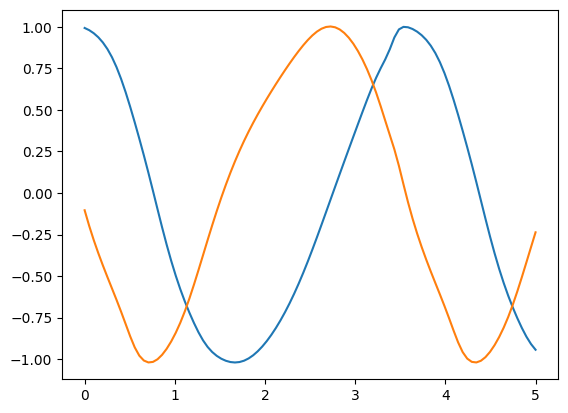

In [8]:
# 解をプロット．データを cpu に持ってきて numpy で扱える型に変換．
res = np.array(xs)
# 第１変数のプロット
plt.plot(teval,res[:,0,0])
# 第２変数のプロット
plt.plot(teval,res[:,0,1])

-4.133434295654297
-4.133432865142822


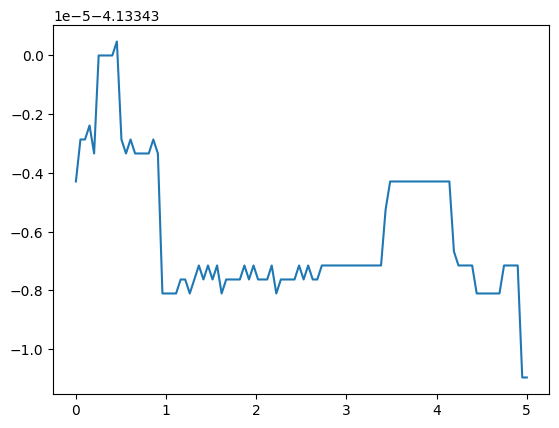

In [9]:
plt.plot(teval,energys)
# グラフ以外に，適当な時刻での値を確認しておく．
print(energys[0])
print(energys[10])